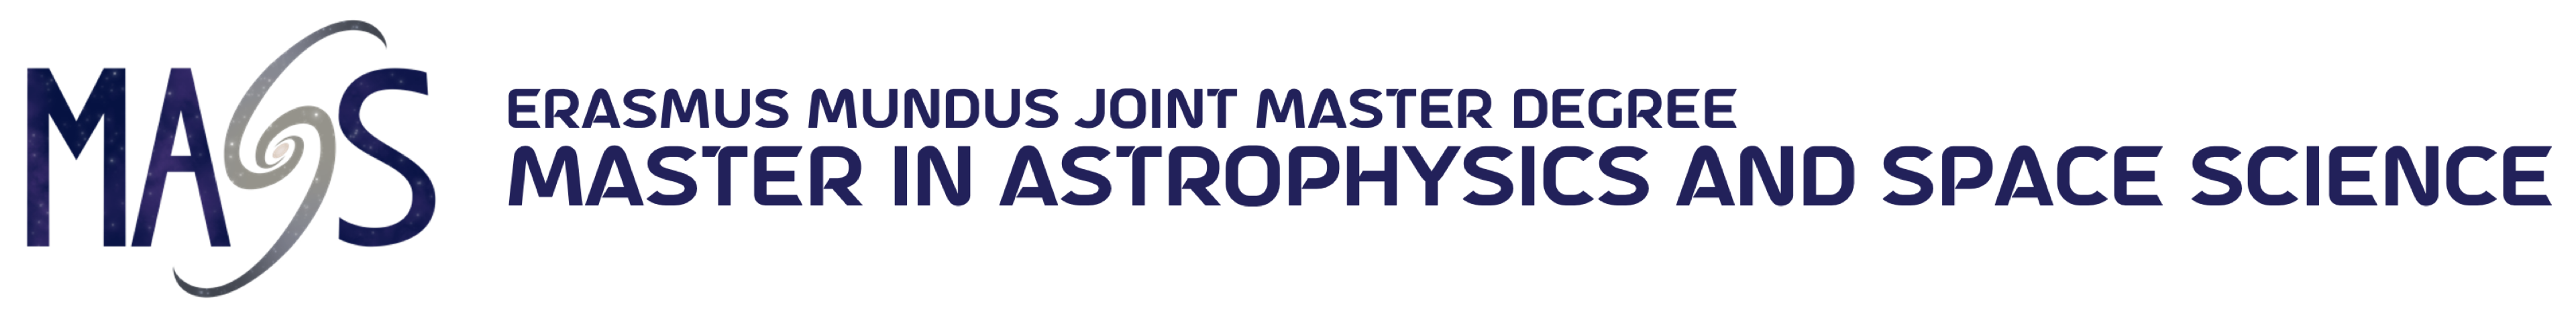

# Classical/Frequentist Statistical Inference: II

## HW #3: Astroinformatics – Astrostatistics and Machine Learning in Astronomy

17 Oct 2024

Student: Francesca Borg

Instructor: Prof. Andjelka B. Kovačević

This notebook is an exercise on classical/frequentist statistical inference following instructions from the astrostatistics course: ['astrostatistics_bicocca_2024'](https://github.com/dgerosa/astrostatistics_bicocca_2024/blob/main/lectures/L05_frequentist.ipynb) written by [Davide Gerosa](https://github.com/dgerosa) for the Università degli Studi di Milano-Bicocca. Note that this course is also based on previous work of many other people. See [here](https://github.com/dgerosa/astrostatistics_bicocca_2024/blob/main/README.md) for credits.

## Fitting A Line To Data <a class="anchor" id="one"></a>


Continuing the theme of last lecture, let's look at one of the most common tasks in statistical inference: **fitting a line to data**. We won't always fit a straight line, but they are prevalent in astronomy since we're potentially examining data over several orders of magnitude. Hence power-law relationships ($y\propto x^\alpha$) become linear relationships in log-log space ($\ln y \propto \alpha\ln x + \mathrm{constant}$).

Assume the noise/scatter in our measurements (the residuals) is generated by a Gaussian process, i.e.:

$$ y_i = a x_i + b + r_i $$

where $r_i$ is drawn from $N(0, \sigma)$. Here, $\sigma$ is the measurement uncertainty, which we take to be the same for all points. The data model includes a linear relationship with two parameters $a,b$: hence the model is written as $M(a,b)$.

Let us compute the likelihood. First, we ask ourselves what is the probability $p(y_i|x_i, M(a, b), \sigma)$ that a particular point $y_i$ would be measured. It is just the normal distribution:

$$ p(y_i|x_i, M(a, b), \sigma) = N(y_i - M(x)|\sigma) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left( - \frac{(y_i - M(x_i))^2}{2 \sigma^2} \right). $$

The likelihood for all data points is given by the product over $N$ of these terms. Given our previous definitions we can then write down the $\ln L$ as

$$ \ln L(a, b) = \mathrm{constant} - \frac{1}{2} \sum_{i=1}^N \frac{(y_i - M(x_i))^2}{\sigma^2} = \mathrm{constant} - \frac{1}{2} \chi^2$$

This is the expression that we now ***maximize*** with respect to $a$ and $b$ to find ML estimators for those parameters. This is equivalent to ***minimizing*** the sum of the squares (the $\chi^2$) in a *least-squares method*.

In [17]:
#import the necessary packages
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

import scipy.stats
from scipy.stats import norm
from scipy.stats import uniform
from scipy import optimize
from astroML import stats as astroMLstats

In [18]:
from astroML.datasets import fetch_hogg2010test #this gives an error

We now read in some almost linear data. For instance, these could be measures of the mass of supermassive black holes as a function of their galactic hosts (the so-called $M$-$\sigma$ relationship).

![](https://s3.amazonaws.com/aasie/images/0004-637X/764/2/184/apj459110f1_lr.jpg)


*Revisiting the Scaling Relations of Black Hole Masses and Host Galaxy Properties*, McConnell & Ma 2013 The Astrophysical Journal 764 184.

Our simplified data contains some **poorly modeled outliers**, which have very different uncertainties from what we assume. Say those galaxies have some features (SMBHs are active) that makes them different.


***The outlier points are the first 4 in the dataset.*** 

In [19]:
# Get data from AstroML: this includes outliers
data = fetch_hogg2010test()
x = data['x'] # x data
y = data['y'] # y data
dy = data['sigma_y'] # uncertainties on y data

print(x)
print(y)
print(dy)

[201. 244.  47. 287. 203.  58. 210. 202. 198. 158. 165. 201. 157. 131.
 166. 160. 186. 125. 218. 146.]
[592. 401. 583. 402. 495. 173. 479. 504. 510. 416. 393. 442. 317. 311.
 400. 337. 423. 334. 533. 344.]
[61. 25. 38. 15. 21. 15. 27. 14. 30. 16. 14. 25. 52. 16. 34. 31. 42. 26.
 16. 22.]


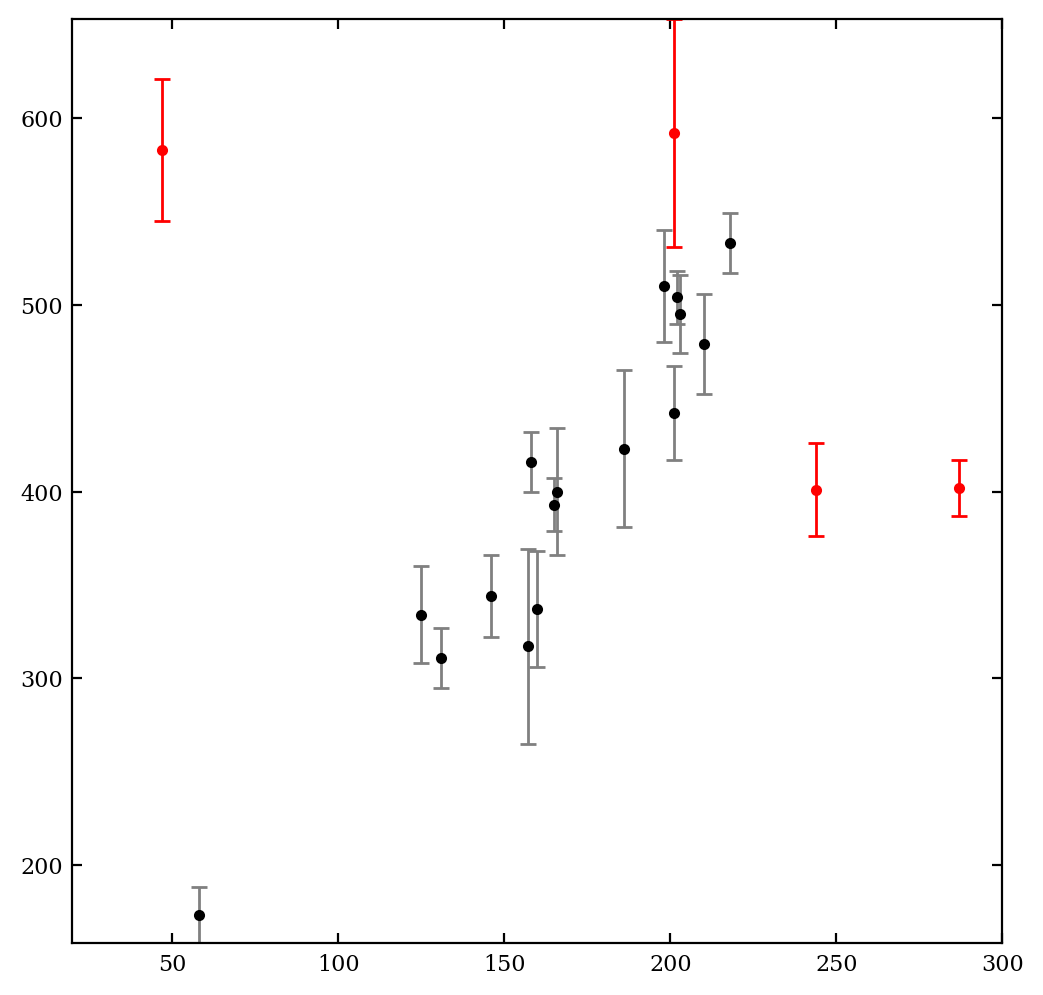

In [20]:
# Plot the results
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

ax.errorbar(x[4:], y[4:], dy[4:], 
            fmt='.k', lw=1, ecolor='gray')

ax.errorbar(x[:4], y[:4], dy[:4], 
            fmt='.', lw=1, c='red');

ax.set_xlim(20,300);

We peform a least-squares (or $\chi^2$) fit of a linear relationship (since this is Gaussian data, we know this means it's also maximizing the likelihood) for both $a$ (the slope) and $b$ (the $y$-intercept).

In [21]:
# Define the standard squared-loss function.
# This is just another name for chi^2
def squared_loss(m, b, x, y, dy):
    y_fit = m * x + b
    return np.sum(((y - y_fit) / dy) ** 2, -1)

# define a lambda function that defines the sum of squared errors.
# these lambda functions are useful!
# let's initially exclude the outliers by chopping off the first 4 points.
f_squared = lambda beta: squared_loss(beta[0], beta[1], 
                                      x=x[4:], y=y[4:], 
                                      dy=dy[4:])

#------------------------------------------------------------
# compute the maximum likelihood 
beta0 = (1, 30) # initial guess for a and b
beta_squared = optimize.fmin(f_squared, beta0)

Optimization terminated successfully.
         Current function value: 18.680770
         Iterations: 53
         Function evaluations: 106


In [22]:
beta_squared

array([ 2.23992089, 34.04772524])

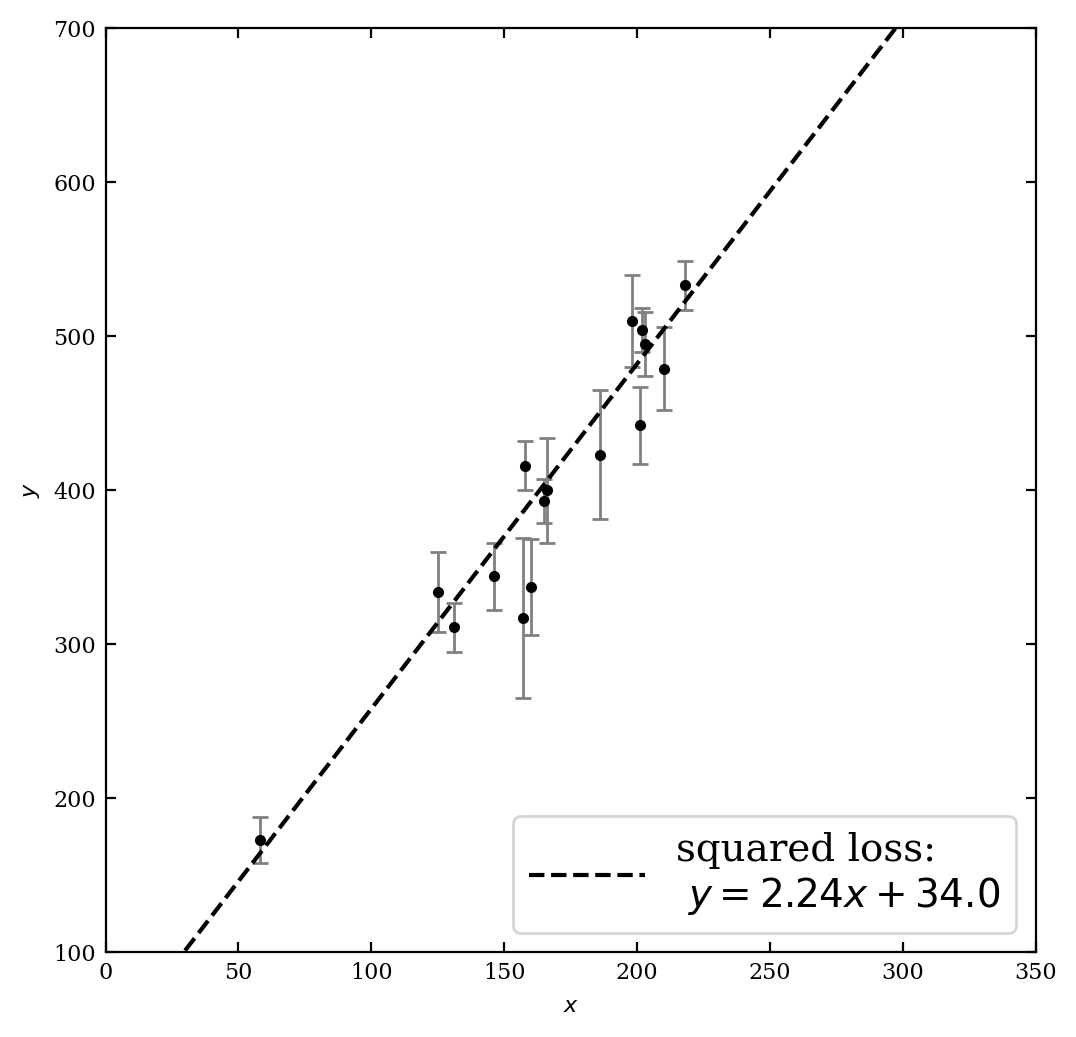

In [23]:
#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

# plot the data
ax.errorbar(x[4:], y[4:], dy[4:], 
            fmt='.k', lw=1, ecolor='gray')

# plot the best fit linear relationship
x_fit = np.linspace(0, 350, 10)
ax.plot(x_fit, beta_squared[0] * x_fit + beta_squared[1], 
        ls='--', color='k',
        label="squared loss:\n $y=%.2fx + %.1f$" % tuple(beta_squared))

ax.set_xlim(0, 350)
ax.set_ylim(100, 700)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.legend(loc=4, prop=dict(size=14))

plt.show()

We'll now include the outlier data points to see how they contaminate the fit, i.e. we don't need to exclude any of the points from our fit.

In [24]:
f_squared = lambda beta: squared_loss(beta[0], beta[1], 
                                      x=x, y=y, 
                                      dy=dy)

beta0 = (1, 30) # initial guess for a and b
beta_squared_outlier = optimize.fmin(f_squared, beta0)

Optimization terminated successfully.
         Current function value: 289.963723
         Iterations: 70
         Function evaluations: 133


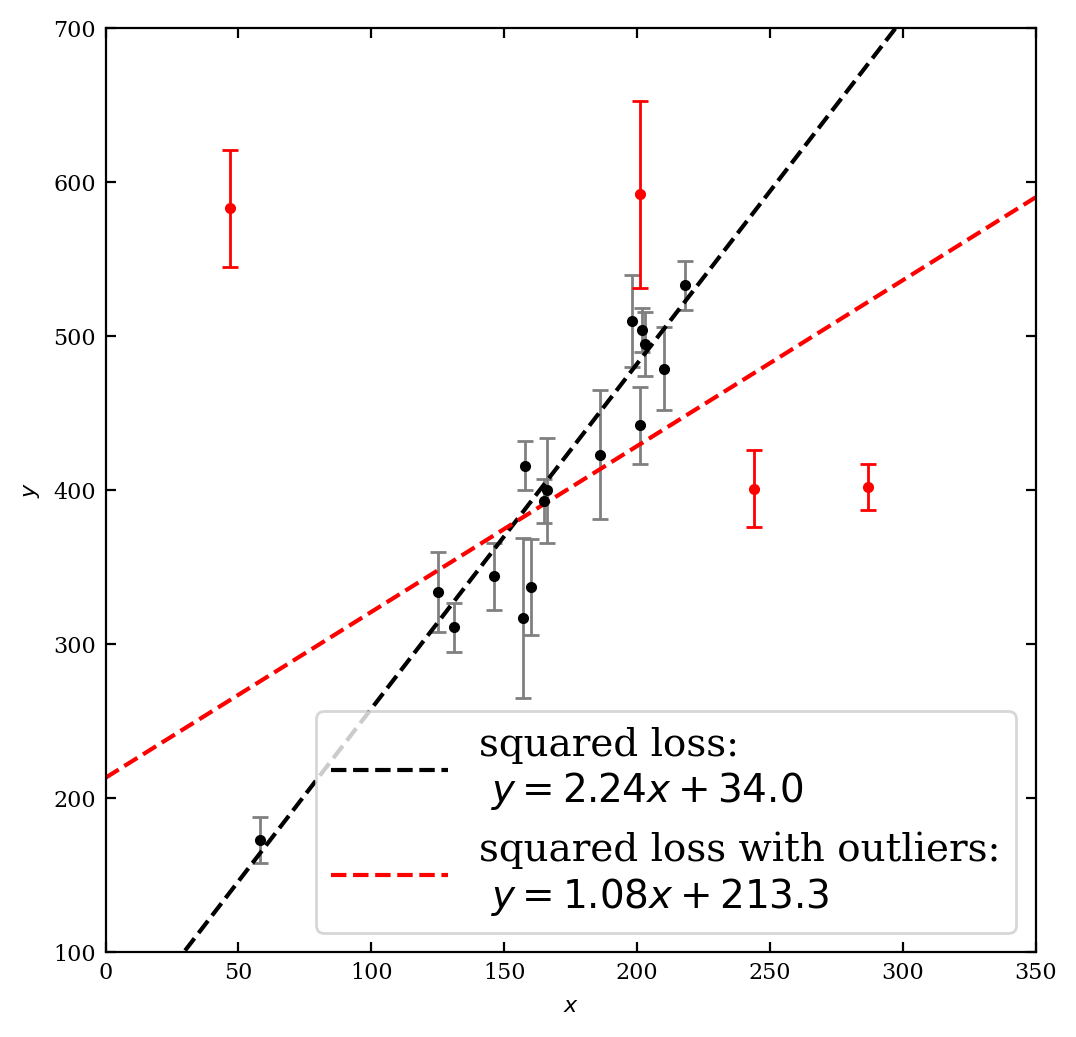

In [25]:
#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

#Plot data
ax.errorbar(x[4:], y[4:], dy[4:], 
            fmt='.k', lw=1, ecolor='gray')

ax.errorbar(x[:4], y[:4], dy[:4], 
            fmt='.', lw=1, c='red');

x_fit = np.linspace(0, 350, 10)
# plot the regular fit from before without outliers
ax.plot(x_fit, beta_squared[0] * x_fit + beta_squared[1], 
        ls='--', color='k',
        label="squared loss:\n $y=%.2fx + %.1f$" % tuple(beta_squared))
# plot the fit that includes outliers
ax.plot(x_fit, beta_squared_outlier[0]*x_fit + beta_squared_outlier[1], 
        ls='--', color='red',
        label="squared loss with outliers:\n $y=%.2fx + %.1f$" % tuple(beta_squared_outlier))

ax.set_xlim(0, 350)
ax.set_ylim(100, 700)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.legend(loc=4, prop=dict(size=14))

plt.show()

That's clearly not right. 

### How do we deal with outliers: modifying the likelihood

- Summing the squares of the residuals ($\chi^2=\sum_{i=1}^N (y_i - M(x_i))^2/\sigma^2$) is sensitive to outliers.

- The $\chi^2$ is an example of an $L_2$ norm (different L here, not the likelihood), where the [$L_p$ norm](https://www.wikiwand.com/en/Lp_space) can be defined as $\sum_{i=1}^N (y_i -M(x_i))^p/\sigma^p$.

- A number of approaches exist for correcting for outliers. See in particular [David Hogg's "Fitting A Model To Data"](https://arxiv.org/abs/1008.4686) paper. 

- These include "sigma-clipping", using interquartile ranges (which you've seen in previous lectures), taking the median of solutions of subsets of the data, and least trimmed squares (which searches for the subset of points that minimizes $\sum_i^N (y_i - \theta_ix_i)^2$).


A standard approach is also changing the **likelihood** to reduce the weight of outliers. This is known as the **Huber loss function**

$$ \sum_{i=1}^N e(y_i|y),$$

where

$$ 
e(t) = \left\{
            \begin{array}{ll}
            \frac{1}{2} t^2 & \mbox{if} \; |t| \leq c, \\
            c|t| - \frac{1}{2} c^2 & \mbox{if} \; |t| \geq c,
            \end{array}
        \right ) 
$$

and 

$$ t = \left|\frac{y-M(x)}{\sigma}\right|.$$

This is continuous and differentiable, and transitions to an $L_1$ norm ($\sum_{i=1}^N |y_i - M(x_i)|$) for large data excursions, which downweights the outlier points.

In the image below, the blue curve is the usual $\chi^2$, $L_2$ parabola shape that we attempt to minimize, whereas the green is the alternative Huber loss function that downweights outliers.

![title](https://upload.wikimedia.org/wikipedia/commons/c/cc/Huber_loss.svg)

In [26]:
# Define the log-likelihood via the Huber loss function
def huber_loss(m, b, x, y, dy, c=1):
    y_fit = m * x + b # model
    t = abs((y - y_fit) / dy) # define t
    mask = t > c # define mask for large excursion points
    
    # apply masking to different points
    # note '~' means 'not'
    return np.sum(np.logical_not(mask) * (0.5 * t ** 2) - \
                  (mask) * c * (0.5 * c - t), -1)


c=1

# lambda function for huber loss 
f_huber = lambda beta: huber_loss(beta[0], beta[1], 
                                  x=x, y=y, dy=dy, c=c)

#------------------------------------------------------------
# compute the maximum likelihood using the huber loss
beta0 = (1, 30)
beta_huber = optimize.fmin(f_huber, beta0)

Optimization terminated successfully.
         Current function value: 43.439758
         Iterations: 62
         Function evaluations: 118


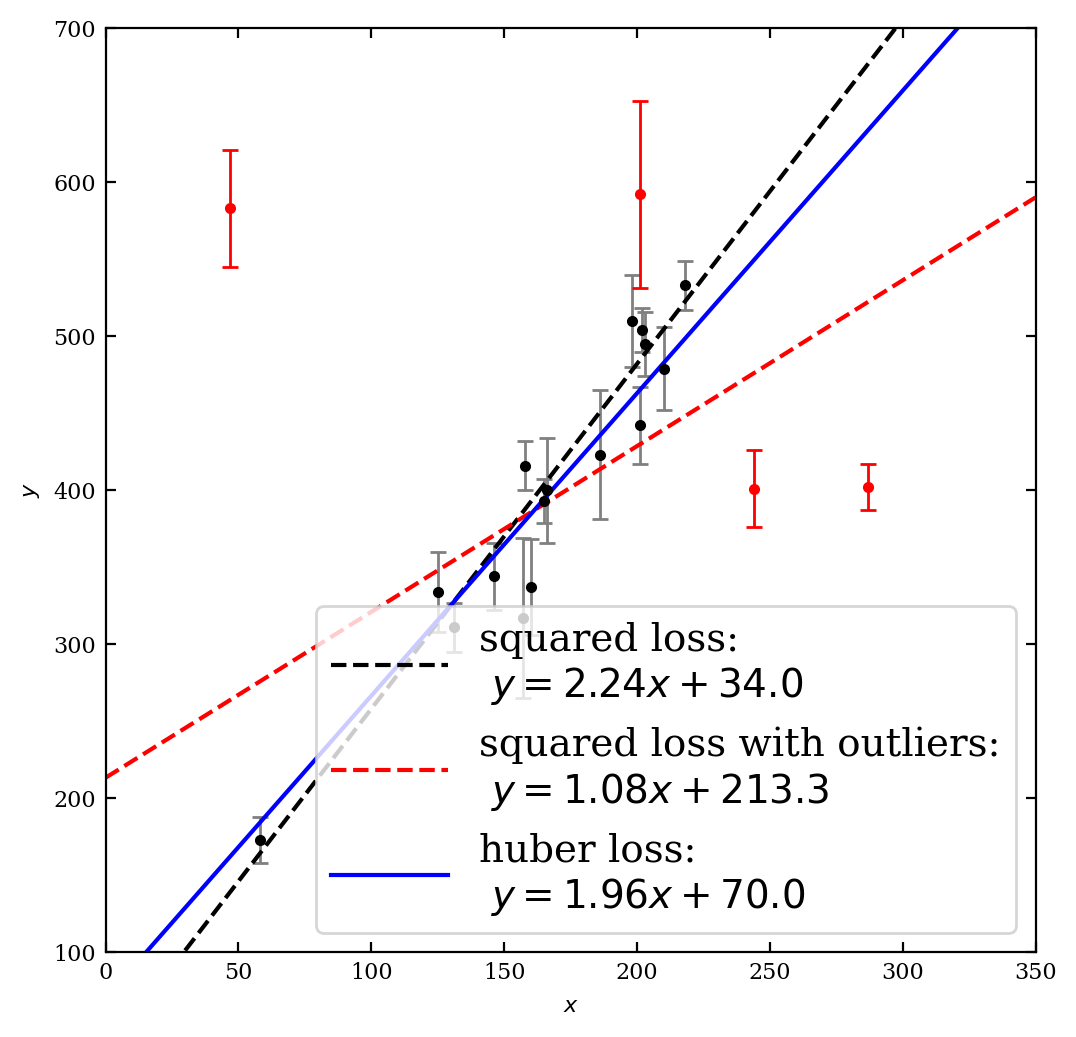

In [27]:
#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

# plot the data without outliers in gray
ax.errorbar(x[4:], y[4:], dy[4:], 
            fmt='.k', lw=1, ecolor='gray')
# plot the outliers in red
ax.errorbar(x[:4], y[:4], dy[:4], 
            fmt='.', lw=1, color='red')

x_fit = np.linspace(0, 350, 10)
# plot the regular fit from before without outliers
ax.plot(x_fit, beta_squared[0] * x_fit + beta_squared[1], 
        ls='--', color='k',
        label="squared loss:\n $y=%.2fx + %.1f$" % tuple(beta_squared))
# plot the fit that includes outliers
ax.plot(x_fit, beta_squared_outlier[0] * x_fit + beta_squared_outlier[1], 
        ls='--', color='red',
        label="squared loss with outliers:\n $y=%.2fx + %.1f$" % tuple(beta_squared_outlier))
# plot the fit with the huber likelihood, downweighting outliers
ax.plot(x_fit, beta_huber[0] * x_fit + beta_huber[1], 
        ls='-', color='blue',
        label="huber loss:\n $y=%.2fx + %.1f$" % tuple(beta_huber))

ax.set_xlim(0, 350)
ax.set_ylim(100, 700)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.legend(loc=4, prop=dict(size=14))

plt.show()

Wow. That's much better! We're frequentists in this lecture, but note how we're still putting prior information into the analysis. We **know** that the error bar on those red points are wrong (they're too small!) so we downeight them accordingly.

Try making $c$ larger (say 5 or 6)...

## Goodness Of Fit & Model Comparison <a class="anchor" id="two"></a>

The MLE approach tells us what the "best" model parameters are, but not how good the fit actually is. If the model is wrong, "best" might not be particularly revealing! Remember this acronym from the dawn of the computer age: ***GIGO = Garbage In, Garbage Out***. 

If we have a crappy model then we shouldn't expect a good fit to the data. For example, if you have $N$ points drawn from a linear distribution, you can always fit the data perfectly with an $N-1$ order polynomial. But that won't help you predict future measurements.

We can describe the **goodness of fit** in words as simply the followng

> *The goodness of fit tells us whether or not it is likely to have obtained the maximum (log-)likelihood $\ln L^0$ by randomly drawing from the data.* 

Using the best-fit parameters of a model, the maximum likelihood value $L^0$ should not be an unlikely occurence. If it is, then our model is not describing the data well. Thus we need to know the *distribution* of $\ln L$ and not just its maximum. For the Gaussian case we have just described, we do a standard transform of variables and compute the so-called $z$ score for each data point (basically the number of standard deviations away from the mean that this point is), writing 

$$z_i = (x_i-\mu)/\sigma,$$ 

then

$$\ln L = {\rm constant} - \frac{1}{2}\sum_{i=1}^N z_i^2 = {\rm constant} - \frac{1}{2}\chi^2.$$

Here, $\chi^2$ is the thing whose distribution we discussed in early lectures.

**So for Gaussian uncertainties, $\ln L$ is distributed as $\chi^2$.**  

Let's rememember how the $\chi^2$ distribution looks like. We've seen this already:

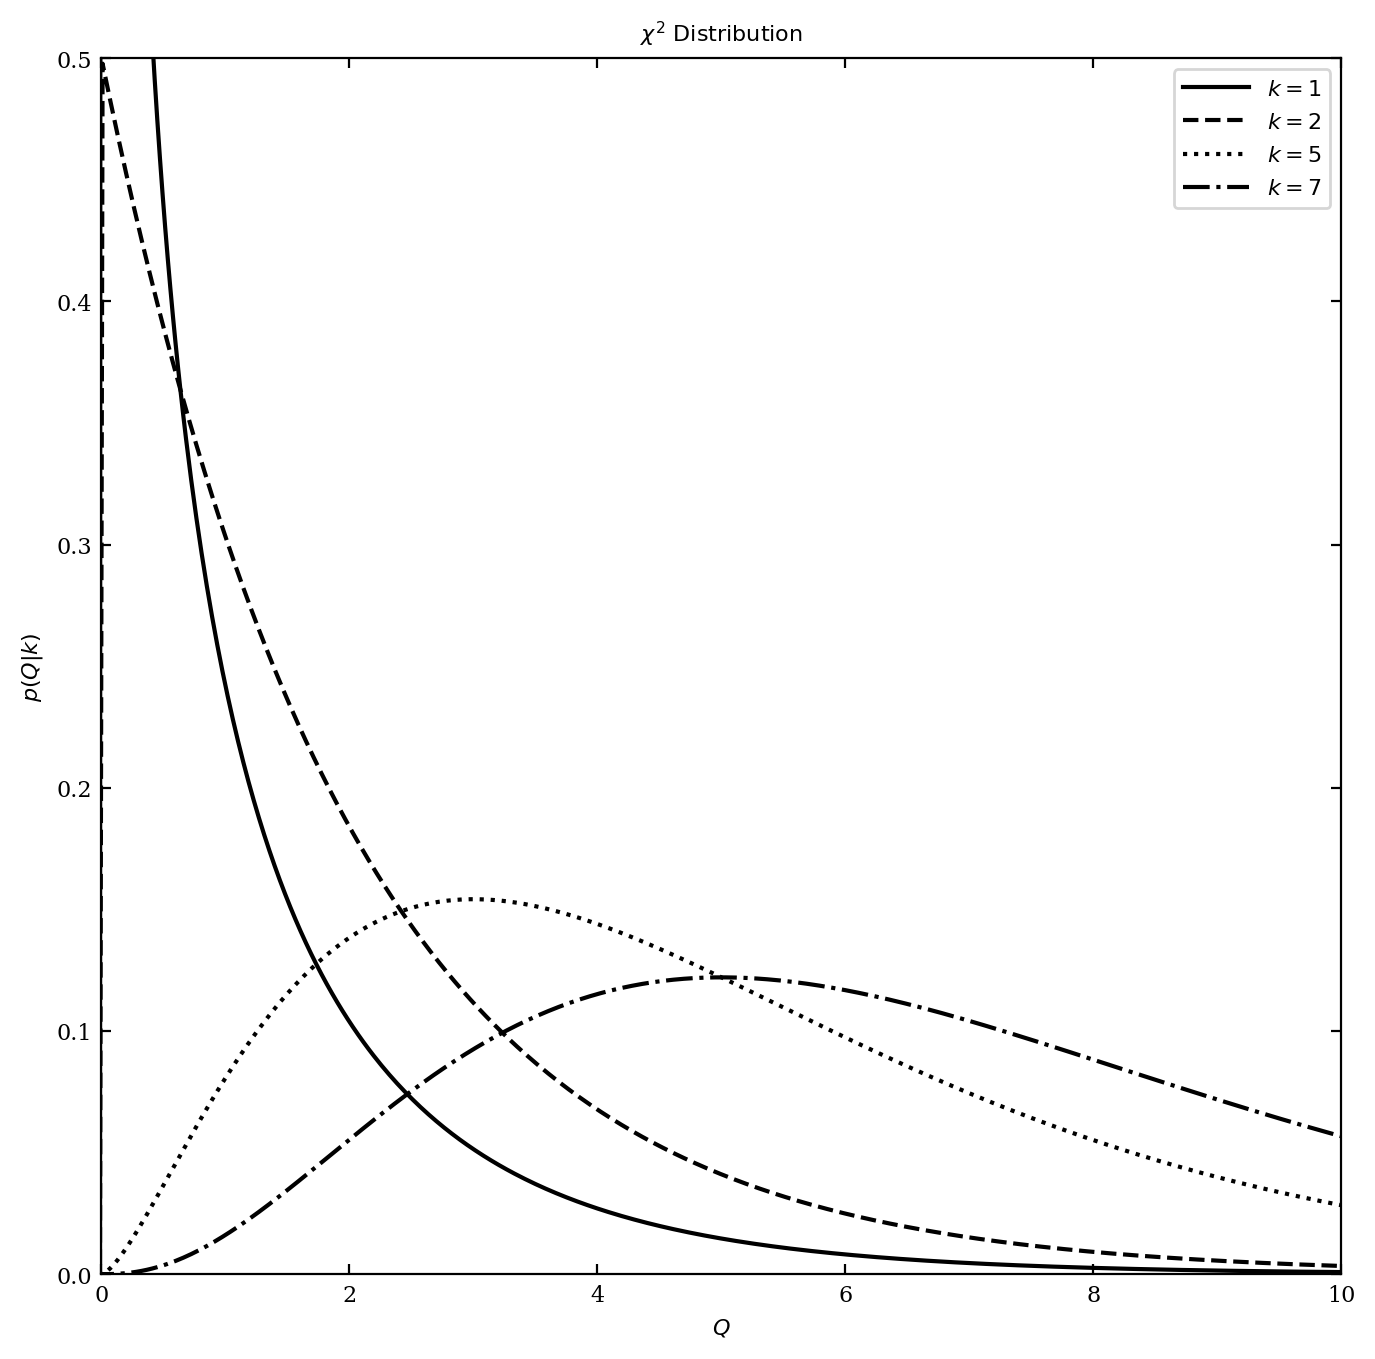

In [28]:
r"""
Example of a chi-squared distribution
---------------------------------------
Figure 3.14.
This shows an example of a :math:`\chi^2` distribution with various parameters.
We'll generate the distribution using::
    dist = scipy.stats.chi2(...)
Where ... should be filled in with the desired distribution parameters
Once we have defined the distribution parameters in this way, these
distribution objects have many useful methods; for example:
* ``dist.pmf(x)`` computes the Probability Mass Function at values ``x``
  in the case of discrete distributions
* ``dist.pdf(x)`` computes the Probability Density Function at values ``x``
  in the case of continuous distributions
* ``dist.rvs(N)`` computes ``N`` random variables distributed according
  to the given distribution
Many further options exist; refer to the documentation of ``scipy.stats``
for more details.
"""
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from scipy.stats import chi2
from matplotlib import pyplot as plt

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

#------------------------------------------------------------
# Define the distribution parameters to be plotted
k_values = [1, 2, 5, 7]
linestyles = ['-', '--', ':', '-.']
mu = 0
xx = np.linspace(-1, 20, 1000)

#------------------------------------------------------------
# plot the distributions
fig, ax = plt.subplots(figsize=(8,8))
fig.subplots_adjust(bottom=0.12)

for k, ls in zip(k_values, linestyles):
    dist = chi2(k, mu)

    plt.plot(xx, dist.pdf(xx), ls=ls, c='black',
             label=r'$k=%i$' % k)

plt.xlim(0, 10)
plt.ylim(0, 0.5)

plt.xlabel('$Q$')
plt.ylabel(r'$p(Q|k)$')
plt.title(r'$\chi^2\ \mathrm{Distribution}$')

plt.legend()
plt.show()

***The mean of the $\chi^2$ distribution is $N-k$ and its standard deviation is $\sqrt{2(N-k)}$.***

We define the $\chi^2$ per degree of freedom, $\chi^2_\mathrm{dof}$, as

$$\chi^2_\mathrm{dof} = \frac{1}{N-k}\sum_{i=1}^N z^2_i.$$

where $k$ is the number of model parameters determined from the data.

- For a good fit, we would expect that $\chi^2_\mathrm{dof}\approx 1$. 
- If $\chi^2_\mathrm{dof}$ is significantly larger than 1, or $(\chi^2_\mathrm{dof}-1)>> \sqrt{2/(N-k)}$, then it is likely that we are not using the correct model.
- If data uncertainties are **(over)under-estimated** then this can lead to improbably **(low)high $\chi^2_\mathrm{dof}$**, as seen below.  

![Ivezic, Figure 4.1](http://www.astroml.org/_images/fig_chi2_eval_1.png)

Read through and execute the following cell to compute $\chi^2_\mathrm{dof}-1$ for the line fitted without outliers and fitted with outliers. These will be compared to the standard deviation of the $\chi^2_\mathrm{dof}-1$ distributions.

In [29]:
# number of data points *without* outliers
N = x[4:].shape[0]
# number of data points *with* outliers
N_outlier = x.shape[0]
# number of model parameters (a,b)
k = 2 

print(x[4:].shape)

# chi2 per dof *without* outliers
chi2 = squared_loss(beta_squared[0], 
                    beta_squared[1], 
                    x=x[4:], y=y[4:], dy=dy[4:])
chi2dof = chi2 / (N-k)

# chi2 per dof *with* outliers
chi2_outlier = squared_loss(beta_squared_outlier[0], 
                            beta_squared_outlier[1], 
                            x=x, y=y, dy=dy)
chi2dof_outlier = chi2_outlier / (N_outlier - k)

# without outliers
found =  chi2dof-1
expected = np.sqrt(2/(N-k))

print("Without outlier. chi2dof-1:", found, "std:", expected, "Nsigma:", found/expected)

# with outliers
found =  chi2dof_outlier-1
expected = np.sqrt(2/(N_outlier-k))

print("With outlier. chi2dof-1:", found, "std:", expected, "Nsigma:", found/expected)


(16,)
Without outlier. chi2dof-1: 0.33434070794594706 std: 0.3779644730092272 Nsigma: 0.8845823663902529
With outlier. chi2dof-1: 15.109095710111468 std: 0.3333333333333333 Nsigma: 45.327287130334405


We divided the measured value by the expected one to get the sigma deviation from the desired value of zero. The lower the better.

### Model Comparison

The distribution of $\ln L$ can only be related to the $\chi^2$ distribution whenever the likelihood is Gaussian. For non-Gaussian likelihoods we can still rank different models in terms of their respectively computed maximum likelihood values, $L^0$. This is only really fair if the models have the same number of parameters.

Let's do that for the data above that contains outliers, both for a model based on the naive squared loss function ($\chi^2$), and a Huber loss function model.

In [30]:
# compute a quantity related to lnL0 for the 
# squared loss function
lnL_sq = - squared_loss(beta_squared_outlier[0], 
                        beta_squared_outlier[1], 
                        x=x, y=y, dy=dy)

# compute a quantity related to lnL0 for the 
# Huber loss function
lnL_huber = - huber_loss(beta_huber[0], 
                         beta_huber[1], 
                         x=x, y=y, dy=dy)

print("Maximum log likelihood for squared loss = %.1f" % lnL_sq)
print("Maximum log likelihood for Huber loss = %.1f" % lnL_huber)

Maximum log likelihood for squared loss = -290.0
Maximum log likelihood for Huber loss = -43.4


Unsurprisingly, the Huber loss function model is much much better (that's in log!).

We need a modified approach whenever the models we're comparing have different numbers of parameters. Such an approach should account for **model complexity** and **effectively penalize models with additional parameters that are not constrained by the data**. This is often called an ***Occam penalty***, because we're trying to incorporate [Occam's Razor](https://www.wikiwand.com/en/Occam%27s_razor#:~:text=Occam's%20razor%2C%20Ockham's%20razor%2C%20Ocham's,is%20usually%20the%20right%20one.).

> *All else being equal (i.e., each model fits the data equally well), the less complex model is favored.*


We'll meet this in extensive detail later, especially in a Bayesian context. But a popular general-purpose tool for model comparison is the **Akaike Information Criterion** (AIC):

$$ \mathrm{AIC}_M \equiv -2\ln[L^0(M)] + 2k + \frac{2k(k+1)}{N-k-1}, $$

where $k$ is the number of model parameters and $N$ is the number of data points.

- For a Gaussian distribution, the first term is equal to $\chi^2$.
- **The model with lowest AIC is the most favored.**
- If all models are equally successful at fitting the data (equal $L^0$ values) then the second and third terms penalize model complexity such that the model with fewest free parameters wins. 

The AIC is a good quick and dirty estimate for the goodness of fit based on some asymptotic approximations (cf.  [Wasserman's textbook](https://link.springer.com/book/10.1007/978-0-387-21736-9) if you're interested). The preferred approach is **cross validation**. Cross validation is at the heart of all deep-learning workflows and will be explored later in the course.

### Bootstrap Method

In bootstrapping, we map the uncertainty of model parameters by re-sampling from our data (with replacement) $B$ times. This is relatively new (Efron, 1979) and was named in inspiration of "*pulling oneself up by one's bootstraps*".

From [this blog](https://erikjanvankesteren.nl/blog/2018-03-01-baron-bootstrap.html): *The word “bootstrap” comes from an old story about a hero - Baron Munchausen - who is riding around on his horse in a forest and suddenly gets stuck in a swamp. He screams for help but there is no one around who hears his voice! Luckily our hero does not give up and gets a great idea: “what if I just pull myself out of this swamp?”. He grabs the straps of his boots and pulls himself loose.*


<img src=https://wordsmith.org/words/images/bootstrap_large.jpg width="300">


It's a way of saying that one creates information seemingly out of nothing. Of course that's not the case, but let's see what this is about... We sample the data **with replacements** (yes, there will be duplicates!).


When sampling from observed data of length $N$ with replacement, there are $N!$ distinct combinations of new observed datasets, and there is only a $N!/N^N$ probability of getting back the original dataset (even for $N=10$ this is only $0.00036$). 

With $B$ new bootstrap datasets, we compute our statistics on each to obtain $B$ measures of our parameters. So, if we have $i=1,\dots,N$ data points in $\{x_i\}$, we draw $N$ of them to make a new sample, where some values of $\{x_i\}$ will be used more than once (and this is ok).

**EXAMPLE**
- We have an original dataset of $1000$ points drawn from a Gaussian distribution. 
- We can only measure the standard deviation of the distribution once with this dataset. 
- Our previous strategies showed that we can use a *Fisher estimate* or an *analytic estimate* of the sample standard deviation uncertainty. 
- Instead, we use the bootstrap method to resample the data $10,000$ times, and compute the standard deviation and $\sigma_G$ on each new dataset. 
- This will map out the uncertainty distribution of those statistics, allowing us to quote confidence limits in our actual measured value. 


## Confidence Estimating: Bootstrap & Jackknife <a class="anchor" id="three"></a>

Most ways of computing confidence limits and uncertainties on measured model parameters assume that the distribution is Gaussian and our samples are large. But even if that is not the case, we can still compute good confidence intervals (e.g., $a<x<b$ with 95\% confidence) using ***resampling*** strategies.

Boostrap and jackknife are the two modern approaches to the problem, which have been made possible by the available computing power. 

Remember that we have a data set $\{x_i\}$ from which we have estimated the distribution as $f(x)$ for a true distribution $h(x)$.  

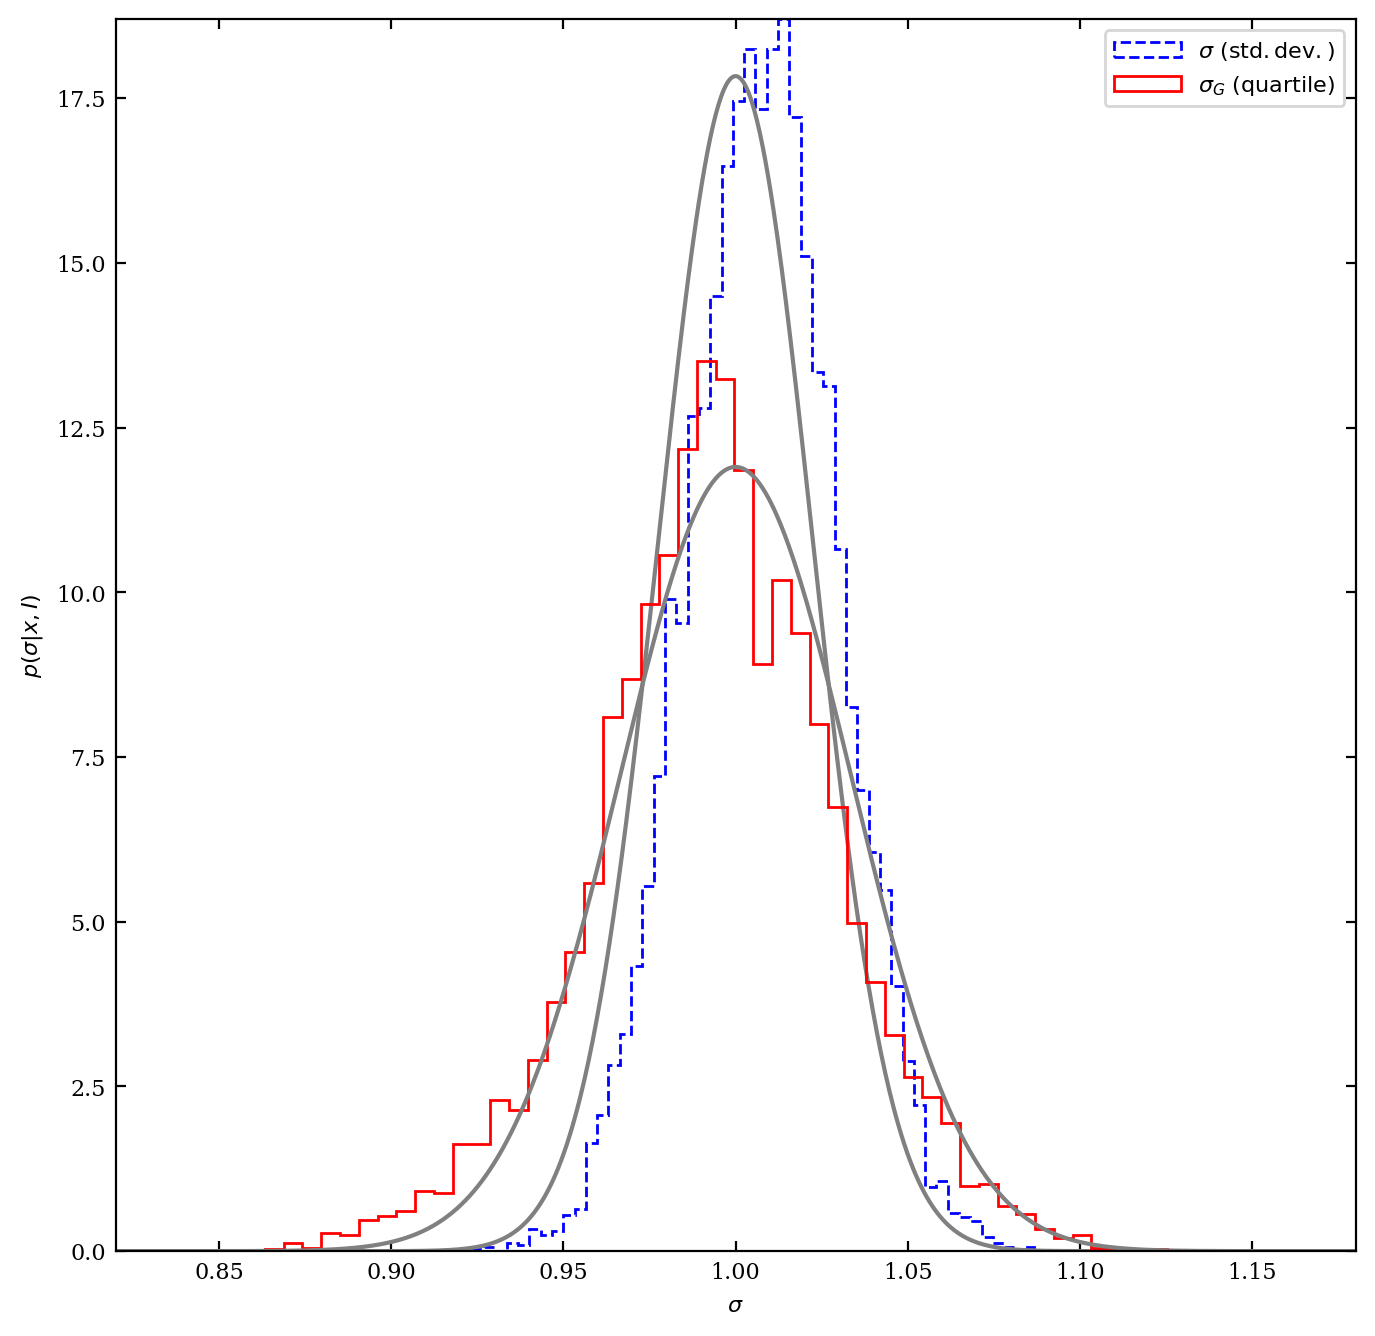

In [31]:
# Ivezic v2, Figure 4.3, modified slightly by GTR and SRT
# %load ../code/fig_bootstrap_gaussian.py
# Author: Jake VanderPlas
# License: BSD

from astroML.resample import bootstrap
from astroML.stats import sigmaG

m = 1000  # number of points
n = 10000  # number of bootstraps

#------------------------------------------------------------
# sample values from a normal distribution
np.random.seed(11)
data = norm(0, 1).rvs(m)

#------------------------------------------------------------
# Compute bootstrap resamplings of data
mu1_bootstrap = bootstrap(data, n, np.std, 
                          kwargs=dict(axis=1, ddof=1))
mu2_bootstrap = bootstrap(data, n, sigmaG, 
                          kwargs=dict(axis=1))

#------------------------------------------------------------
# Compute the theoretical expectations for the two distributions
xgrid = np.linspace(0.8, 1.2, 1000)

sigma1 = 1. / np.sqrt(2 * (m - 1))
pdf1 = norm(1, sigma1).pdf(xgrid)

sigma2 = 1.06 / np.sqrt(m)
pdf2 = norm(1, sigma2).pdf(xgrid)

#------------------------------------------------------------
# Plot the results
fig, ax = plt.subplots(figsize=(8, 8))

ax.hist(mu1_bootstrap, bins=50, density=True, 
        histtype='step', color='blue', ls='dashed', 
        label=r'$\sigma\ {\rm (std. dev.)}$')
ax.plot(xgrid, pdf1, color='gray')

ax.hist(mu2_bootstrap, bins=50, density=True, 
        histtype='step', color='red', 
        label=r'$\sigma_G\ {\rm (quartile)}$')
ax.plot(xgrid, pdf2, color='gray')

ax.set_xlim(0.82, 1.18)
ax.set_xlabel(r'$\sigma$')
ax.set_ylabel(r'$p(\sigma|x,I)$')
ax.legend()

plt.show()

The above shows the bootstrap uncertainty estimates for the sample standard deviation $\sigma$ (blue dashed) and $\sigma_G$ (red solid). The thin grey lines show Gaussians with the theoretical widths determined as $\sigma_s = s\, / \sqrt{2(N - 1)}$ and $\sigma_{\sigma_G} = 1.06\, s\, / \sqrt{N}$.

### Jackknife Method 

This is similar to bootsrapping except that we don't use a sample size of $N$. Rather, ***we leave off one or more of the observations*** from $\{x_i\}$. As with bootstrap, we do this multiple times, generating samples from which we can determine our uncertainties.

- If we leave out just one datapoint each time, we can make $N$ such datasets that each contain $(N-1)$ data points.
- We compute our statistic or find our model parameters in each of these jackknife datasets.

For jackknifing by leaving out one datapoint, the bias-corrected jackknife estimate of a statistic $\alpha$ is

$$ \alpha^J = \alpha_N + \Delta\alpha,$$

where $\alpha_N$ is the statistic computed on the original dataset, and 

$$ \Delta\alpha = (N-1)\left( \alpha_N - \frac{1}{N}\sum_{i=1}^N \alpha^*_i \right)$$

where $\{\alpha_i^*\}$ are the statistics computed on the $N$ jackknife datasets. 

For asymptoticically normal estimators, the standard error on $\alpha^J$ is

$$ \sigma_\alpha = \sqrt{\frac{1}{N(N-1)}\sum_{i=1}^N [N\alpha_N - \alpha^J - (N-1)\alpha^*_i]^2}.$$

Confidence limits on $\alpha$ can be computed using the Student's $t$ distribution with $t=(\alpha-\alpha^J)/\sigma_\alpha$ and $(N-1)$ degrees of freedom.

**NOTES**
- The jackknife standard error is more reliable than the bias correction.
- Standard jackknife (removing one point) does well for statistics like the mean and standard deviation, but is poor with rank-based statistics (e.g., median, quantiles, $\sigma_G$). 
- This is because (as we've seen) rank-based statistics are not very sensitive to adding/removing single data points. So jackknifing can give many identical values of the statistic!
- This can be resolved by modifying the jackknife to leave off more than one datapoint.


**EXAMPLE**
- We compute jackknife uncertainty estimates for the width of a Gaussian distribution, using the same data as in the bootstrap example.
- The $N$ jackknife estimates of $\sigma$ and $\sigma_G$ will be shown, but the `astroML` jackknife method automatically incorporates the bias correction mentioned above.


1.0015366861435233 0.02228013942047898
0.597747861971019 0.031353107946452324
mu_1 mean: 1.00 +- 0.02
mu_2 mean: 0.60 +- 0.03


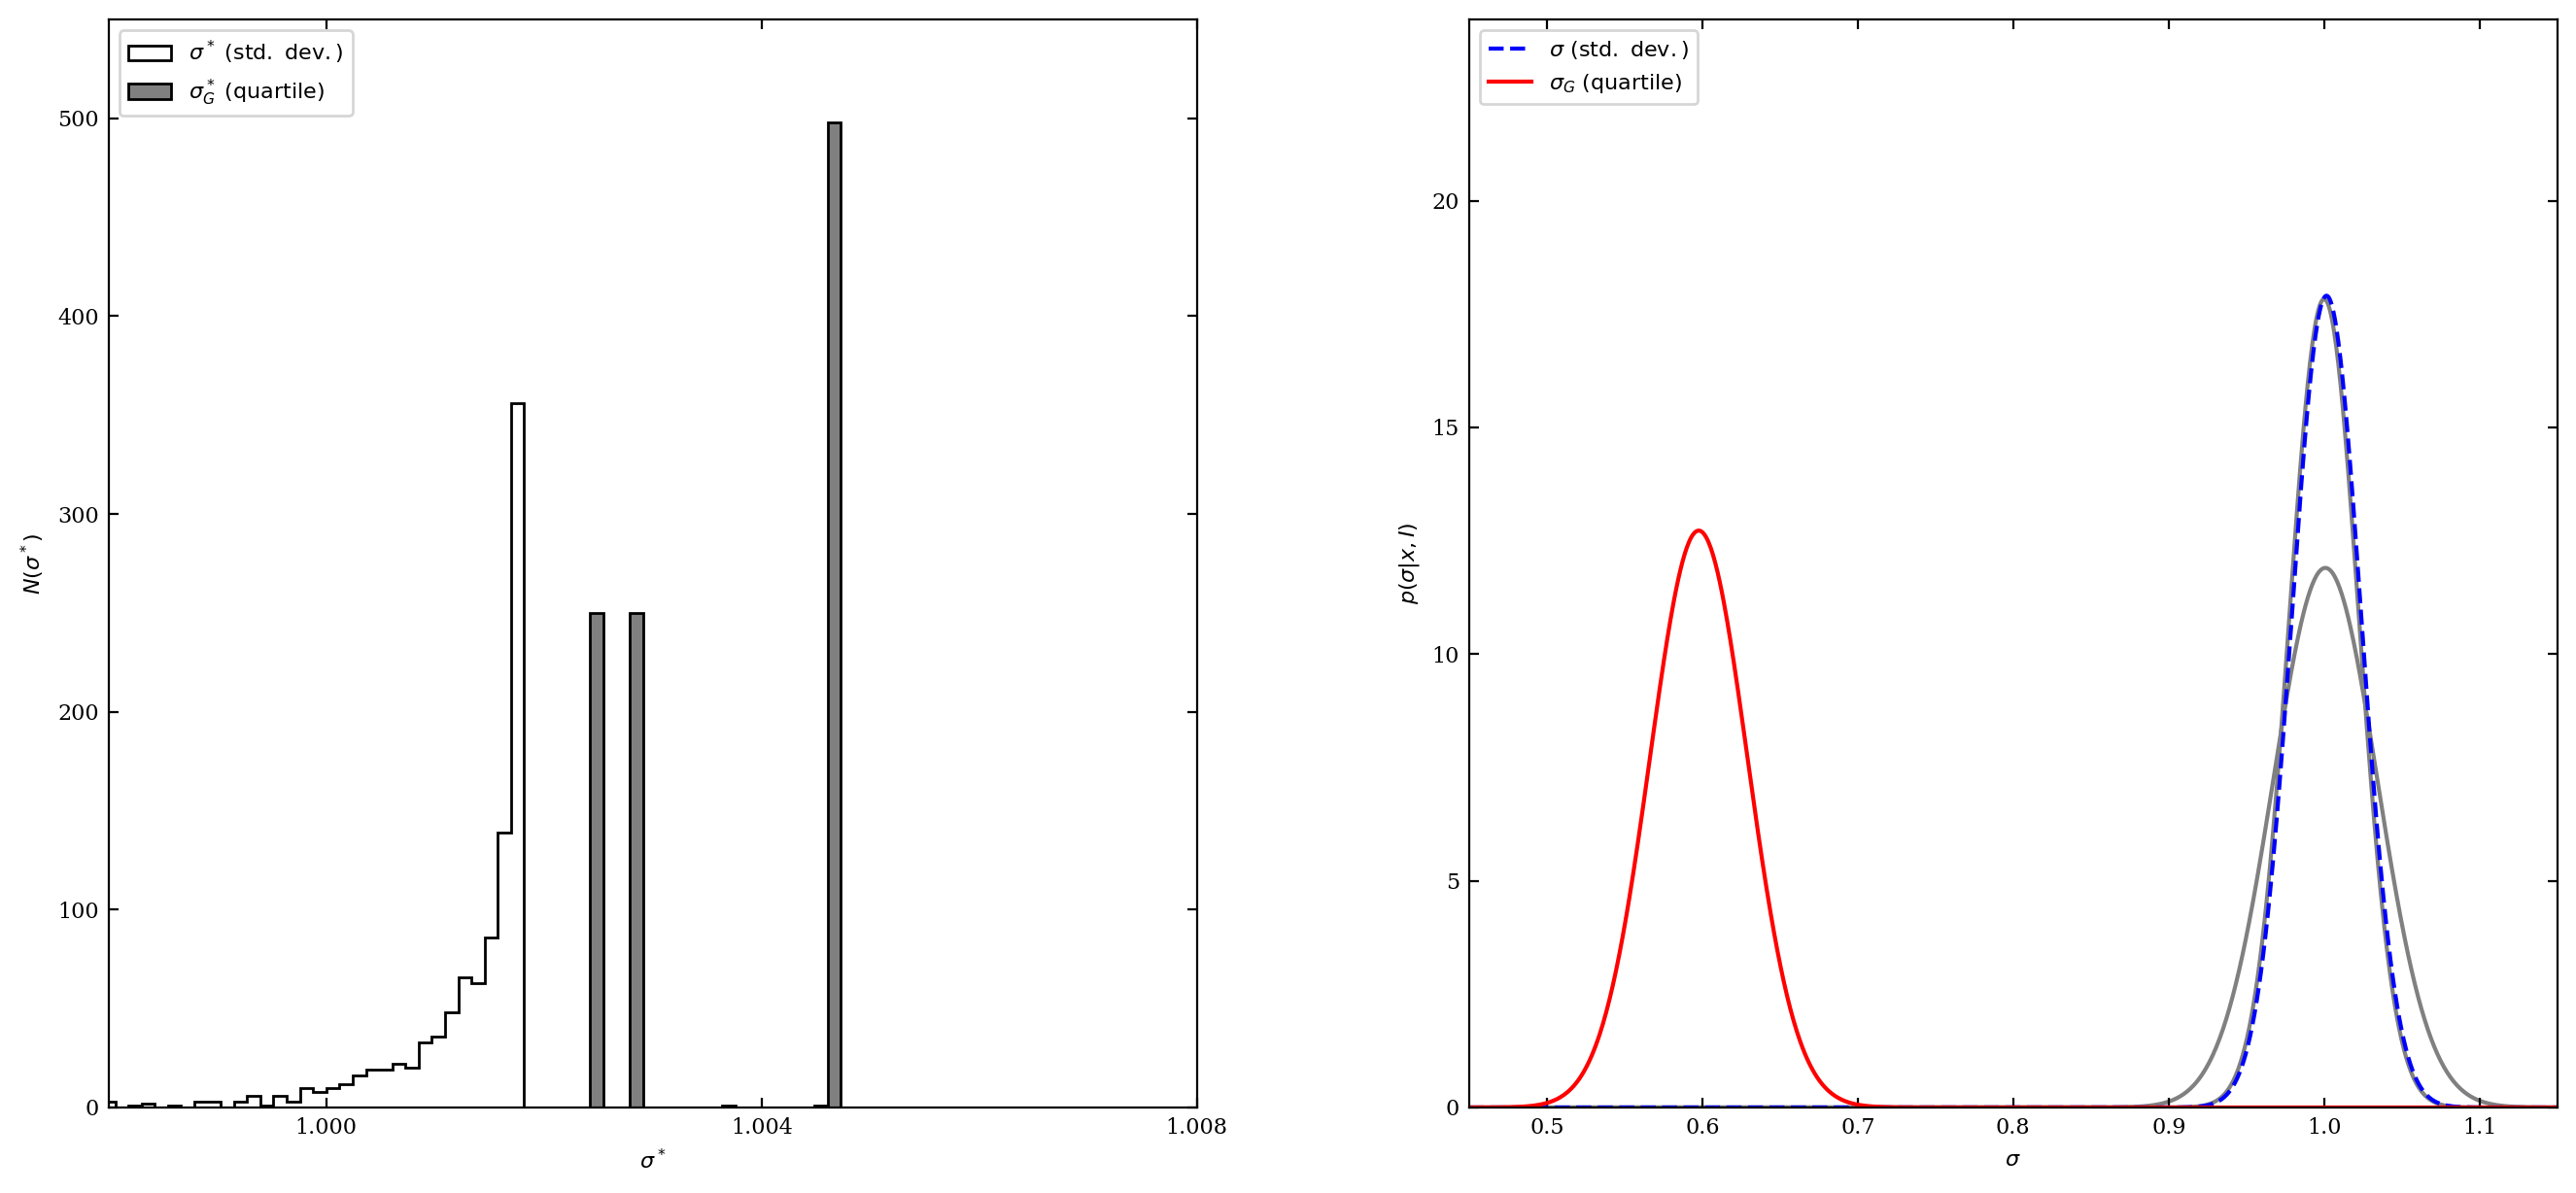

In [32]:
# Ivezic v2, Figure 4.4, modified slightly by SRT
# %load ./code/fig_jackknife_gaussian.py
# Author: Jake VanderPlas
# License: BSD

from astroML.resample import jackknife
from astroML.stats import sigmaG

m = 1000  # number of points
n = 10000  # number of bootstraps

#------------------------------------------------------------
# sample values from a normal distribution
np.random.seed(123)
data = norm(0, 1).rvs(m)

# mu1 is the mean of the standard-deviation-based width
mu1, sigma_mu1, mu1_raw = jackknife(data, np.std,
                                    kwargs=dict(axis=1, ddof=1),
                                    return_raw_distribution=True)

pdf1_theory = norm(1, 1. / np.sqrt(2 * (m - 1)))
pdf1_jackknife = norm(mu1, sigma_mu1)
print(mu1, sigma_mu1)

# mu2 is the mean of the interquartile-based width
#  WARNING: do not use the following in practice.  This example
#           shows that jackknife fails for rank-based statistics.
mu2, sigma_mu2, mu2_raw = jackknife(data, sigmaG,
                                    kwargs=dict(axis=1),
                                    return_raw_distribution=True)
pdf2_theory = norm(data.std(), 1.06 / np.sqrt(m))
pdf2_jackknife = norm(mu2, sigma_mu2)
print(mu2, sigma_mu2)

#------------------------------------------------------------
# plot the results
print("mu_1 mean: %.2f +- %.2f" % (mu1, sigma_mu1))
print("mu_2 mean: %.2f +- %.2f" % (mu2, sigma_mu2))

fig = plt.figure(figsize=(15, 8))
fig.subplots_adjust(left=0.11, right=0.95, bottom=0.2, top=0.9,
                    wspace=0.25)

# plot all jacnknife results on histogram
ax = fig.add_subplot(121)
ax.hist(mu1_raw, np.linspace(0.996, 1.008, 100),
        label=r'$\sigma^*\ {\rm (std.\ dev.)}$',
        histtype='stepfilled', fc='white', 
        ec='black', density=False)
ax.hist(mu2_raw, np.linspace(0.996, 1.008, 100),
        label=r'$\sigma_G^*\ {\rm (quartile)}$',
        histtype='stepfilled', fc='gray', 
        density=False)
ax.legend(loc='upper left', handlelength=2)

ax.xaxis.set_major_locator(plt.MultipleLocator(0.004))
ax.set_xlabel(r'$\sigma^*$')
ax.set_ylabel(r'$N(\sigma^*)$')
ax.set_xlim(0.998, 1.008)
ax.set_ylim(0, 550)

# plot the bias-corrected jackknife estimates
ax = fig.add_subplot(122)
x = np.linspace(0.45, 1.15, 1000)
ax.plot(x, pdf1_jackknife.pdf(x),
        color='blue', ls='dashed', 
        label=r'$\sigma\ {\rm (std.\ dev.)}$',
        zorder=2)
ax.plot(x, pdf1_theory.pdf(x), 
        color='gray', zorder=1)
ax.plot(x, pdf2_jackknife.pdf(x),
        color='red', 
        label=r'$\sigma_G\ {\rm (quartile)}$', 
        zorder=2)
ax.plot(x, pdf2_theory.pdf(x), 
        color='gray', zorder=1)
plt.legend(loc='upper left', handlelength=2)


ax.set_xlabel(r'$\sigma$')
ax.set_ylabel(r'$p(\sigma|x,I)$')
ax.set_xlim(0.45, 1.15)
ax.set_ylim(0, 24)

plt.show()

The **left panel** shows a histogram over all $N$ jackknife datasets of the widths determined using the sample standard deviation, and using $\sigma_G$ (from the interquartile range). 

The **right panel** shows the bias-corrected jackknife estimates (see above) for the two methods. The gray lines show the theoretical results as before in the bootstrap example. The jackknife result for $\sigma$ matches the theoretical result almost exactly, but note the failure of the jackknife to correctly estimate $\sigma_G$. *Jackknifing does poorly for rank-based statistics!*

### When to bootstrap or jackknife?

- Jackknife estimates are usually easier to calculate, easier to apply for complex sampling schemes, and automtically remove bias.
- Bootstrap is better for computing confidence intervals because it maps out the full distribution of the statistic instead of assuming asymptotic normality.
- Bootstrap is random resampling so gives different results each time. Whereas jackknifing gives repeatable results.

It is generally a good idea to use both methods and compare the results. Use either/both with caution with $N$ is small!

But in general, **cross validation** is the way to go. We'll see this carefully in a few lectures.

#### Example from my own research in general relativity (or "it looks so nasty but sometime boostrpping is the only thing one can do")

Pacilio, Gerosa, Baghwat 2023: "*The cosmic variance of testing general relativity with gravitational-wave catalogs*" https://arxiv.org/abs/2310.03811

Here we try to use gravitational-wave events to test general relativity (questions like: is that the correct theory of gravity, do black holes truly have an event horizon, etc etc). 

Any single signal is going to give you a constraint, which in practice is weak. The hope ("stacking") is to perform more stringent tests by putting many events together. But when using all the events, how can you possibily quantify confindence in that results? By definition, there is only one datasets that contains all the events. So we bootstrapped the set of events to obtain multiple realizations of the catalogs (thank you Baron Munchausen).


### Time to get your hands dirty. Black-hole binary formation channels with gaussian mixtures.

Many problems in astrophysics give rise to data with multiple modes. This is typically because different processes physical processes contribute to the observed dataset. 

For instance, one of the most outstanding question in gravitational-wave astrophysics is the formation channel of binary black holes. Leading scenarions include the evolution of isolated binaries in the galactic field and the dynamica assembly of sources in dense environments like globular clusters.


Right now, state-of-the-art analyses seems to say that many channels are all at play. This is a plot by [Zevin et al (2020)](https://arxiv.org/abs/2011.10057)


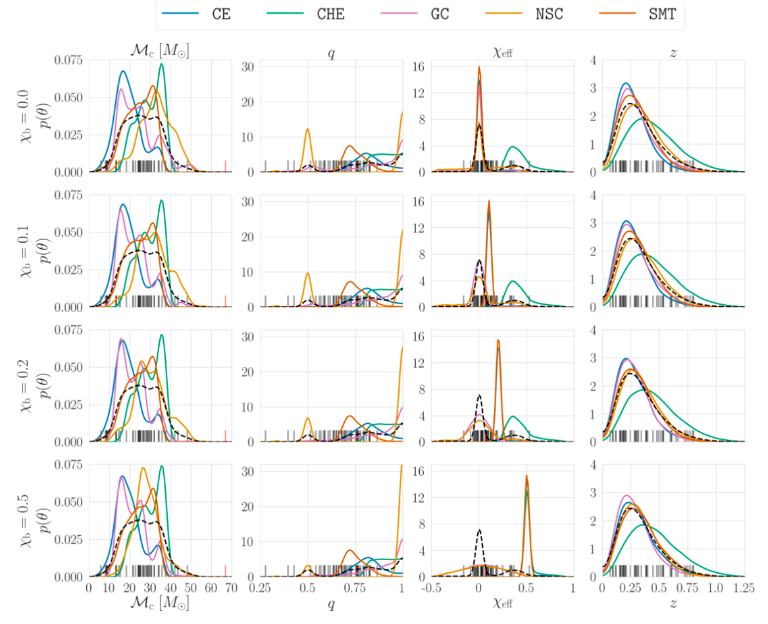

where they consider 5 possibilities for the formation of black hole binaries: common envelop (CE), chemically omogenous stars (CHE), globular clusters (GC), nuclear star clusters (NSC) and stable mass transfer (SMT). 

If you want to know more about LIGO-driven astrophysics and black hole binaries formation channels, these are some recent reviews: [Mandel and Farmer (2021)](https://arxiv.org/abs/1806.05820), [Mapelli (2021)](https://arxiv.org/abs/2106.00699), [Gerosa and Fishbach (2021)](https://arxiv.org/abs/2105.03439).

Anyway. LIGO measures the masses of many black holes. You can find the dataset at `solutions/formationchannels.npy`.


*Hint*: Note that the data provided are of shape (N,1), not (N,). This might be confusing at first, but it's the format that sklearn wants (more on this in a future lecture).  A useful tool to convert between the two is [np.newaxis](https://stackoverflow.com/questions/29241056/how-does-numpy-newaxis-work-and-when-to-use-it).

In [6]:
x=np.linspace(0, 5, 6)
print(x, x.shape)
print(x[np.newaxis,:], x[np.newaxis,:].shape)
print(x[:,np.newaxis], x[:,np.newaxis].shape)

[0. 1. 2. 3. 4. 5.] (6,)
[[0. 1. 2. 3. 4. 5.]] (1, 6)
[[0.]
 [1.]
 [2.]
 [3.]
 [4.]
 [5.]] (6, 1)


Some events form in different astrophysical environments than others. **You want to figure out how many of formation channels are at play.**


The strategy here is to fit a Gaussian Mixture model: that is, my model is a sum of $N$ gaussians each with mean $\mu_j$ and standard deviation $\sigma_j$ and weight $\alpha_j$:

$p(x_i|\theta) = \sum_{j=1}^N \alpha_j \mathcal{N}(\mu_j,\sigma_j) $

This depends on $3N-1$ parameters (not $3N$ because the sum of the $\alpha_j$ must be unity to ensure that this is a probability.

#### Tasks

1) Load this file (`np.load`) and complete a quick **exploration of the data**. How many modes do you think you see?


In [33]:
import matplotlib.pyplot as plt

In [34]:
data = np.load('formationchannels.npy')

In [35]:
print(data.min())
print(data.max())

-4.965425000732701
48.70124451852294


<>:2: SyntaxWarning: invalid escape sequence '\o'
<>:2: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_12820/879641951.py:2: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel('Black hole mass $[M_\odot]$')


Text(0.5, 1.0, 'Histogram of data')

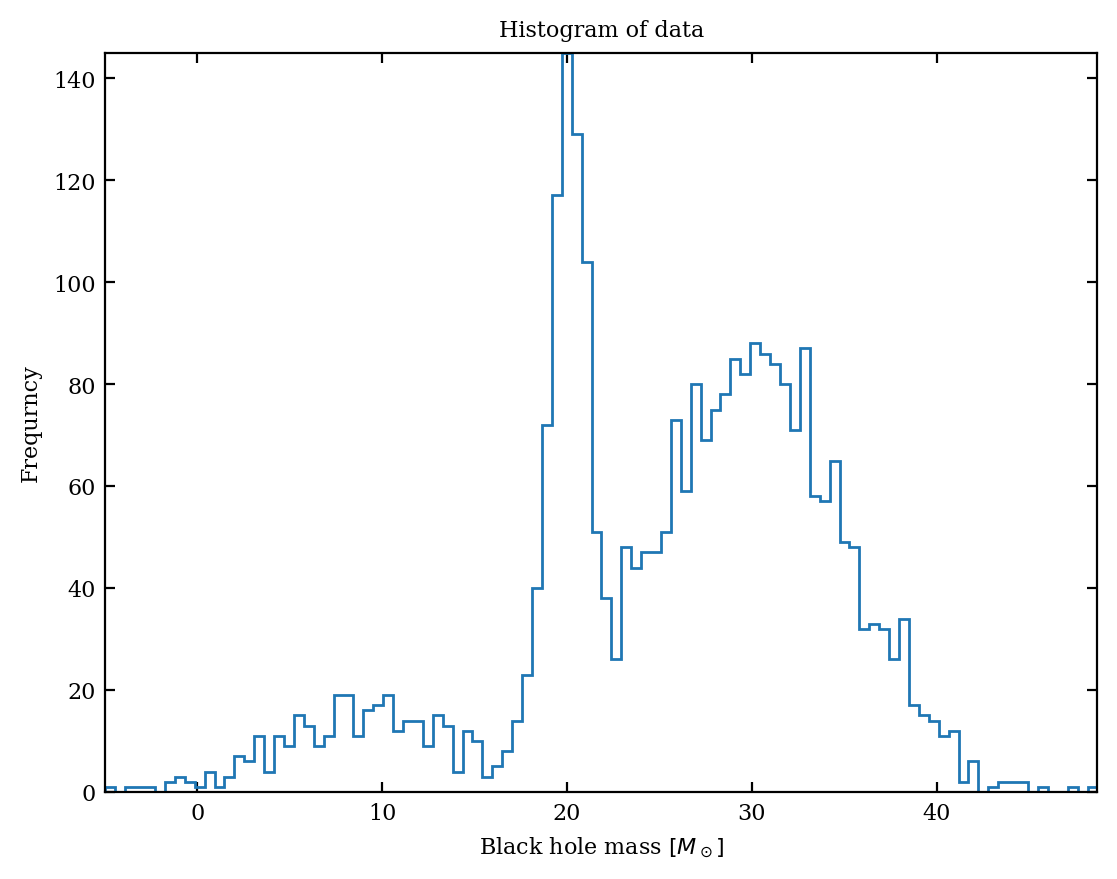

In [36]:
plt.hist(data, bins=100, histtype='step')
plt.xlabel('Black hole mass $[M_\odot]$')
plt.ylabel('Frequrncy')
plt.title('Histogram of data')

There are 3 Gaussian modes (we observe roughly 3 peaks).

2) Take some time to explore `sklearn.mixture.GaussianMixture`. Check the documentation, some examples, the help menu, etc. You first need to define the model (instance of a class), and then train it on the data using the `fit` method (the data provided are already in the right numpy format!). This will output the trained model, which has various attributes.

*Note*. We'll do a more formal introduction to scikit-learn in one of the next lectures. This is meant to be a formative example on how you might find yourself dealing with a library you've never seen before. This happens *all the time* in scientific research!

In [38]:
from sklearn.mixture import GaussianMixture

Some information about the model: uses an **expectation-maximization (EM)** algorithm approach to find the **best mixture of Gaussians for the data**. This is an iterative method to find the (local) maximum likelihood or maximum a posteriori (MAP) estimates of parameters in statistical models, where the model depends on unobserved latent variables.

Note that **latent variables** are ones which can only be inferred indirectly through a mathematical model from **observable variables** that can be directly observed or measured.

3) Complete the fit 10 times with $N=1,...,10$ Gaussians. 

Note: `sklearn` by default will use the so-called [Expectation-Maximization algorithm](https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm), which is one of the many great things in data science we don't have time to study in detail.

In [40]:
# fit models with 1-10 components
N = np.arange(1, 10)
models = [None for i in range(len(N))]

for i in range(len(N)):
    models[i] = GaussianMixture(N[i]).fit(data)

4) For each of this fits, compute the AIC (easy! It's a attribute of the trained model!). Plot $N$ vs AIC: which model is preferred?

In [42]:
#computing the AIC

AIC = [m.aic(data) for m in models]

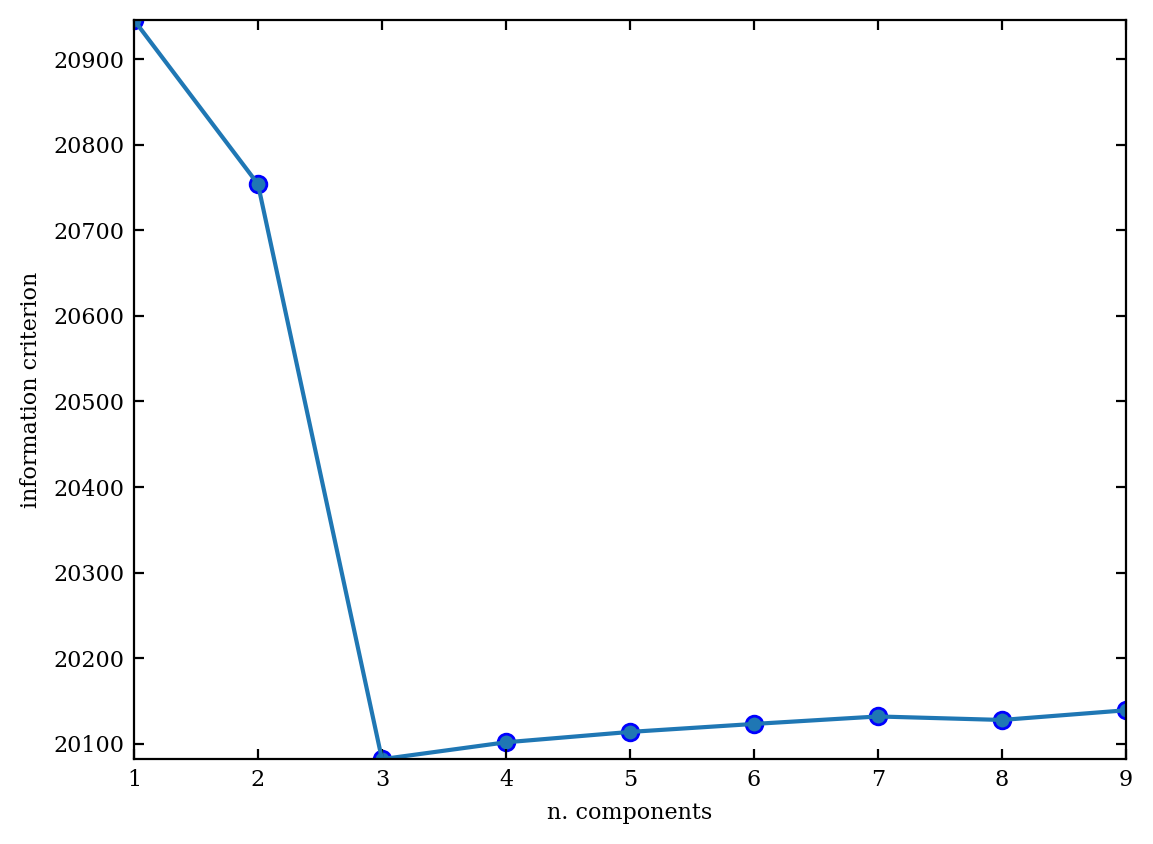

In [43]:
#plot N vs. AIC

plt.plot(N, AIC,)
plt.scatter(N, AIC)

plt.xlabel('n. components')
plt.ylabel('information criterion');

In [44]:
#find the number of components at which the AIC is minimized. This is our preferred model.

print('The AIC is minimized for N=', N[np.argmin(AIC)])

The AIC is minimized for N= 3


The AIC is a good quick and dirty estimate for the goodness of fit based on some asymptotic approximations (cf.  [Wasserman's textbook](https://link.springer.com/book/10.1007/978-0-387-21736-9) if you're interested). The preferred approach is **cross validation**. Cross validation is at the heart of all deep-learning workflows and will be explored later in the course.

**Akaike Information Criterion** (AIC) formula:

$$ \mathrm{AIC}_M \equiv -2\ln[L^0(M)] + 2k + \frac{2k(k+1)}{N-k-1}, $$

where $k$ is the number of model parameters and $N$ is the number of data points.

- For a Gaussian distribution, the first term is equal to $\chi^2$.
- **The model with lowest AIC is the most favored.**
- If all models are equally successful at fitting the data (equal $L^0$ values) then the second and third terms penalize model complexity such that the model with fewest free parameters wins. 

5) Plot the preferred solution on top of the input data. You should get a very nice fit!

In [45]:
#preferred solution is model with MIN AIC
M_best = models[np.argmin(AIC)]

<>:11: SyntaxWarning: invalid escape sequence '\o'
<>:11: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_12820/3050234190.py:11: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel("Black hole mass $[M_\odot]$")


Text(0.5, 0, 'Black hole mass $[M_\\odot]$')

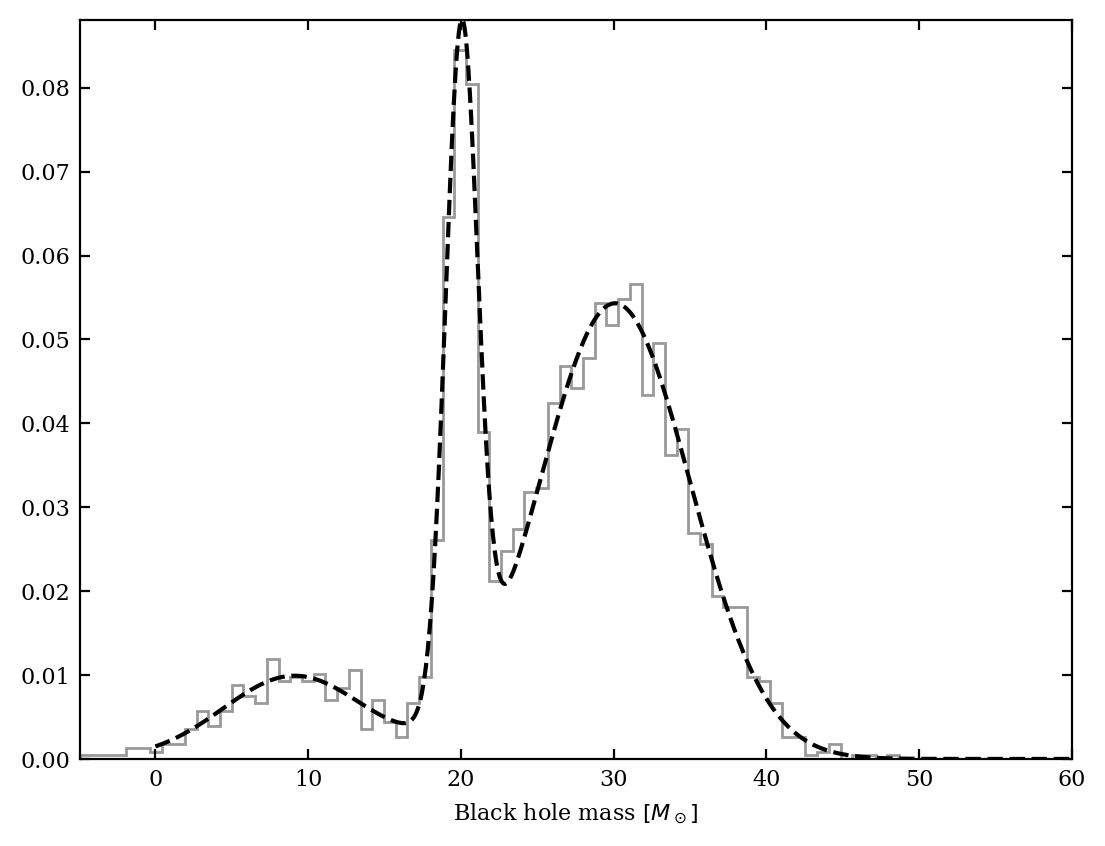

In [47]:
#plotting preferred solution

x = np.linspace(0, 60, 1000)
logprob = M_best.score_samples(x.reshape(-1, 1))
pdf = np.exp(logprob)

plt.hist(data, 70, density=True, histtype='step', alpha=0.4,color='black')

plt.plot(x, pdf, '--k')

plt.xlabel("Black hole mass $[M_\odot]$")

6) Understand (i.e. plot) which Gaussian mode corresponds to which part of the input dataset. 

*Hint:* Useful methods here are `score_samples` and `predict_proba`: you'll need them both. Try to understand what they do and how you can put them together.

<>:11: SyntaxWarning: invalid escape sequence '\o'
<>:11: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_12820/3034758558.py:11: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel("Black hole mass $[M_\odot]$")


Text(0.5, 0, 'Black hole mass $[M_\\odot]$')

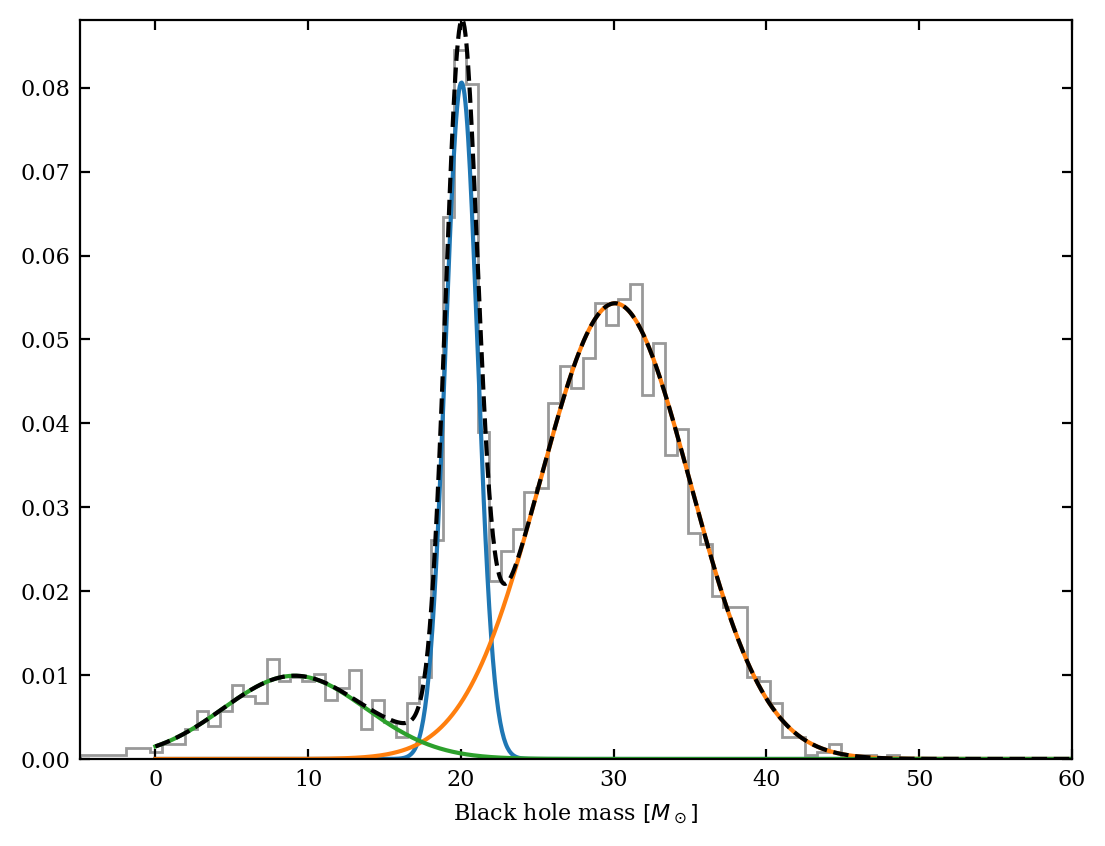

In [49]:
#plotting the individual modes
responsibilities = M_best.predict_proba(x.reshape(-1, 1))
pdf_individual = responsibilities * pdf[:, np.newaxis]

plt.hist(data, 70, density=True, histtype='step', alpha=0.4,color='black')
plt.plot(x, pdf_individual[:,0], c='C0')
plt.plot(x, pdf_individual[:,1], c='C1')
plt.plot(x, pdf_individual[:,2], c='C2')
plt.plot(x, pdf, '--k')

plt.xlabel("Black hole mass $[M_\odot]$")

<>:12: SyntaxWarning: invalid escape sequence '\o'
<>:12: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_12820/501848532.py:12: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel("Black hole mass $[M_\odot]$")


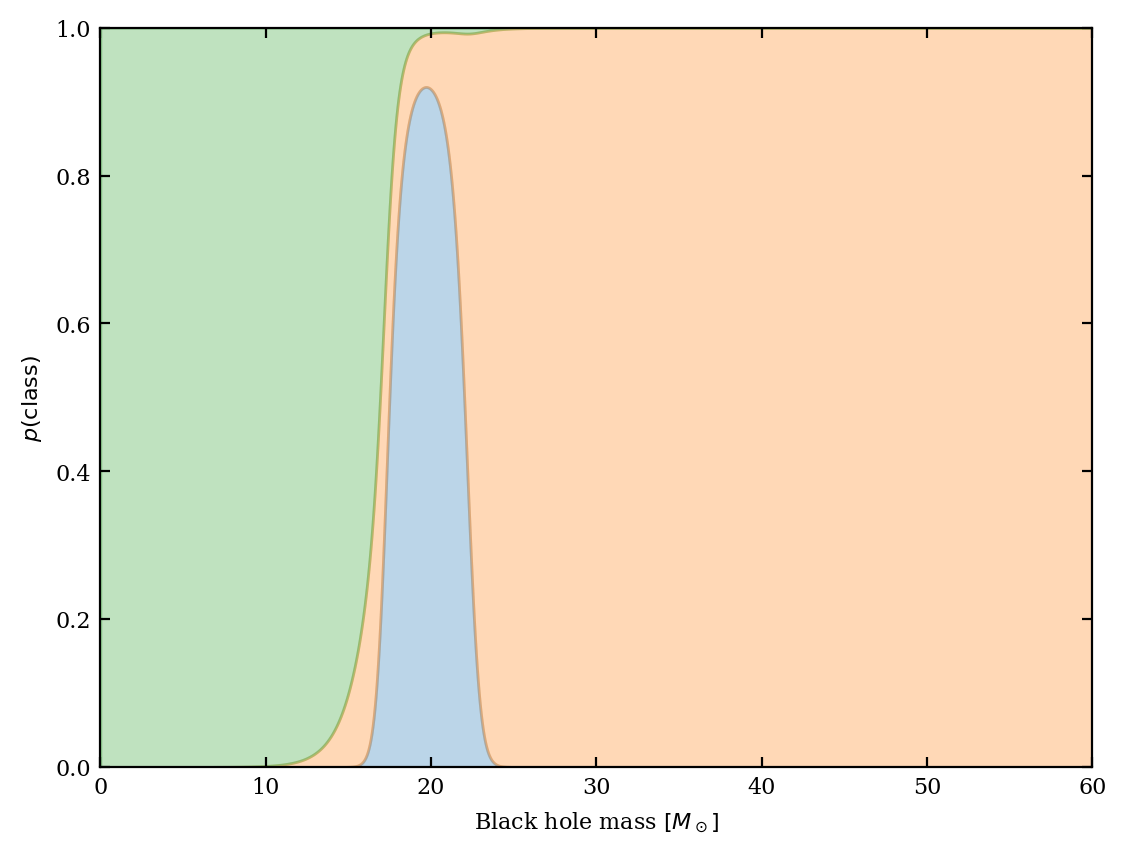

In [50]:
#another way of representing the responsibilities

p = responsibilities
#p = p[:, (0, 1, 2)]  # rearrange order so the plot looks better
p = p.cumsum(axis=1).T

plt.fill_between(x, 0, p[0], color='C0', alpha=0.3)
plt.fill_between(x, p[0], p[1], color='C1', alpha=0.3)
plt.fill_between(x, p[1], 1, color='C2', alpha=0.3)
#plt.xlim(-6, 6)
plt.ylim(0, 1)
plt.xlabel("Black hole mass $[M_\odot]$")

plt.ylabel(r'$p({\rm class})$');

#plt.text(-5, 0.3, 'class 1', rotation='vertical')
#plt.text(0, 0.5, 'class 2', rotation='vertical')
#plt.text(3, 0.3, 'class 3', rotation='vertical')

The AIC is flat beyond N-3.

**Innovation: add an additional node** to compare the results

<>:9: SyntaxWarning: invalid escape sequence '\o'
<>:9: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_12820/2059329153.py:9: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel("Black hole mass $[M_\odot]$")


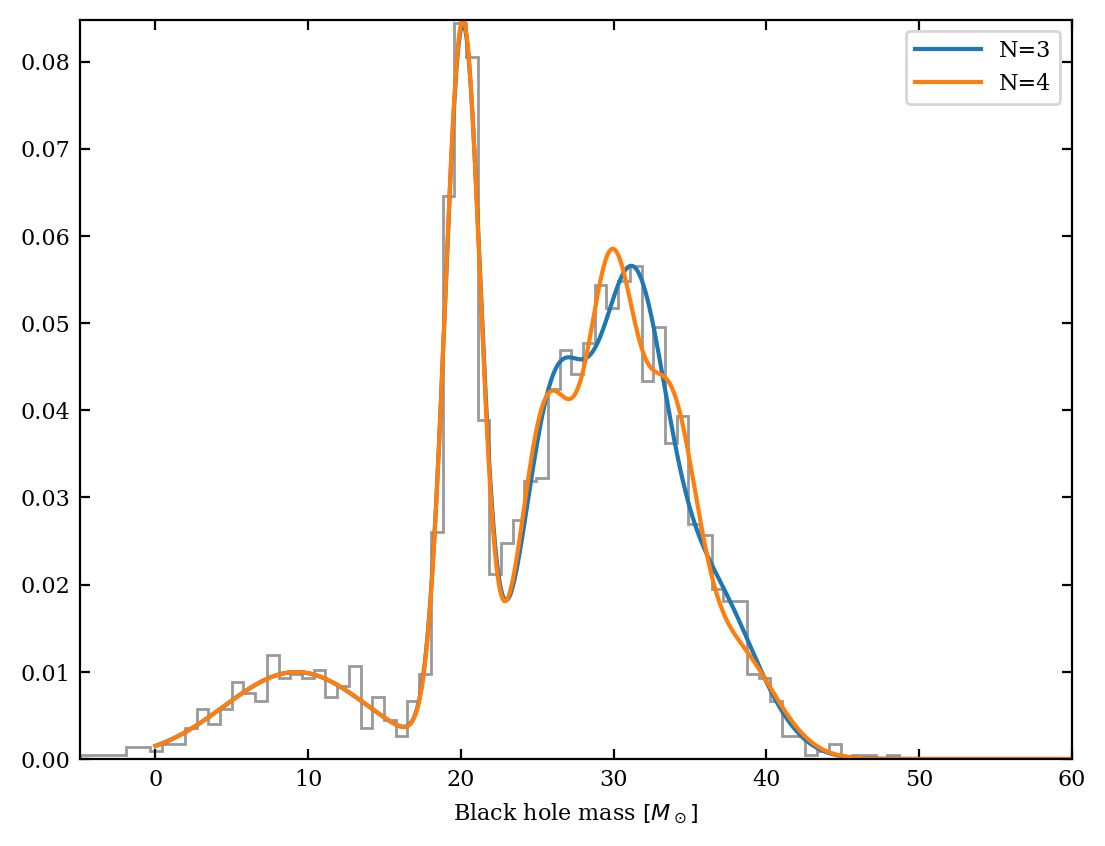

In [52]:
plt.hist(data, 70, density=True, histtype='step', alpha=0.4,color='black')

logprob = models[4].score_samples(x.reshape(-1, 1))
plt.plot(x, np.exp(logprob),label='N=3')

logprob = models[5].score_samples(x.reshape(-1, 1))
plt.plot(x, np.exp(logprob),label='N=4')

plt.xlabel("Black hole mass $[M_\odot]$")
plt.legend();

N=4 gives a pretty good fit too. Is it better? Let's use BIC - a different goodness-of-fit estimator which is a variation of AIC to see whether this would give us the result that there is a better model than N=3.

**BIC** is the **Bayesian Information Criterion** (also called Schwarz information criterion) which is a criterion for model selection among a finite set of models; models with lower BIC are generally preferred.

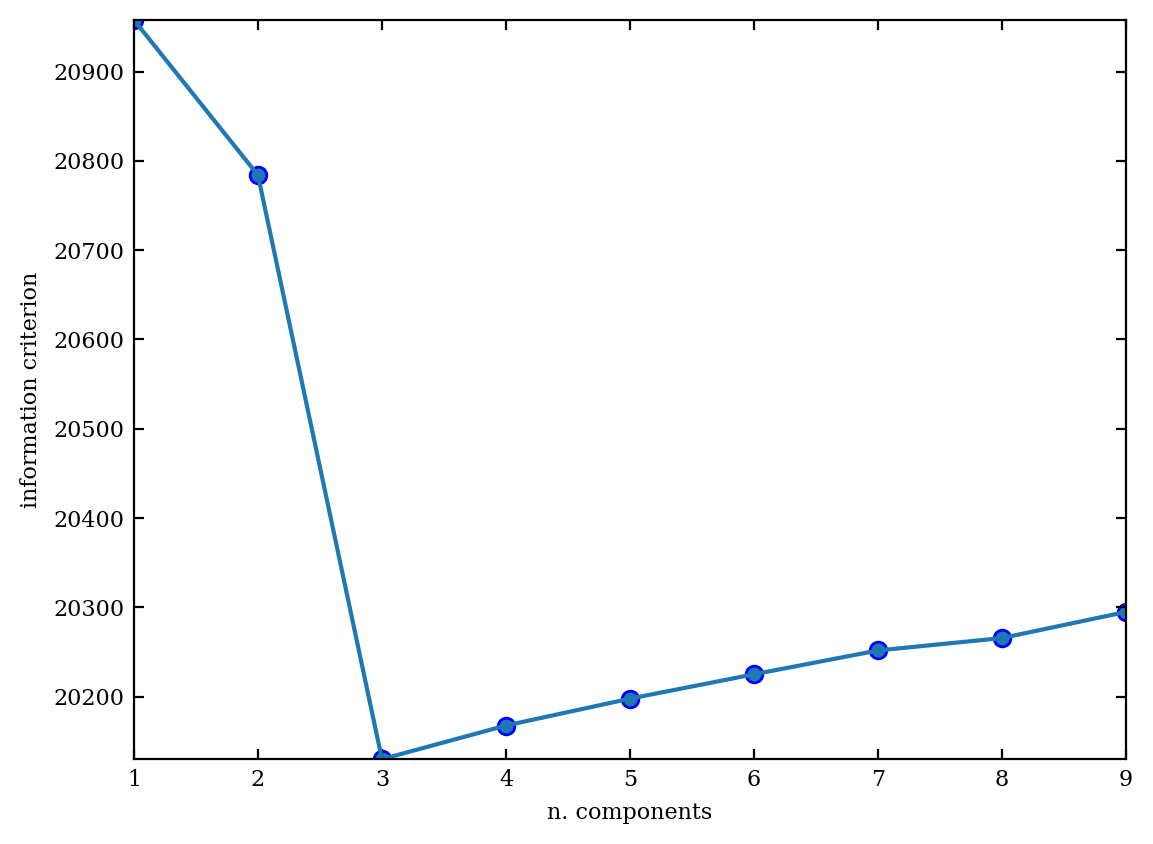

In [55]:
BIC = [m.bic(data) for m in models]
plt.plot(N, BIC,)
plt.scatter(N, BIC)
plt.xlabel('n. components')
plt.ylabel('information criterion');

In [56]:
#find the number of components at which the BIC is minimized. This is our preferred model.

print('The BIC is minimized for N=', N[np.argmin(BIC)])

The BIC is minimized for N= 3


This gives the same result, that the preferred model is N=3.